In [ ]:
import pandas as pd
import sklearn
import numpy
import nltk
import matplotlib.pyplot as plt
import seaborn as sb

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import xgboost as xgb

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving flipkart_full_data.csv to flipkart_full_data.csv


In [ ]:
data=pd.read_csv('/content/flipkart_full_data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


In [ ]:
data.describe()

,product_name,product_price,Rate,Review,Summary,Sentiment
count,205052,205052,205052,180388,205041,205052
unique,958,525,8,1324,92923,3
top,cello Pack of 18 Opalware Cello Dazzle Lush Fi...,1299,5,wonderful,good,positive
freq,6005,9150,118765,9016,17430,166581


In [ ]:
data['comments']=data['Review'] + ' ' + data['Summary']

In [ ]:
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,comments
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive,super! great cooler excellent air flow and for...
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive,awesome best budget 2 fit cooler nice cooling
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive,fair the quality is good but the power of air ...
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative,useless product very bad product its a only a fan
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral,fair ok ok product


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180379 entries, 0 to 205051
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   180379 non-null  object
 1   product_price  180379 non-null  object
 2   Rate           180379 non-null  object
 3   Review         180379 non-null  object
 4   Summary        180379 non-null  object
 5   Sentiment      180379 non-null  object
 6   comments       180379 non-null  object
dtypes: object(7)
memory usage: 11.0+ MB


In [ ]:
data['Rate'].value_counts()

5                                                                    105641
4                                                                     36966
1                                                                     18294
3                                                                     14024
2                                                                      5451
Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)              1
Bajaj DX 2 L/W Dry Iron                                                   1
Nova Plus Amaze NI 10 1100 W Dry Iron?ÃÂ¿?ÃÂ¿(Grey & Turquoise)         1
Name: Rate, dtype: int64

In [ ]:
data['Sentiment'].value_counts()

positive    147171
negative     24401
neutral       8807
Name: Sentiment, dtype: int64

In [ ]:
good_reviews=data[data['Sentiment']=='positive']
bad_reviews = data[data['Sentiment']=='negative']
nue_reviews=data[data['Sentiment'] == 'neutral']

NameError: ignored

In [ ]:
good_reviews_text = " ".join(good_reviews.comments.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.comments.to_numpy().tolist())
nue_reviews_text=" ".join(nue_reviews.comments.to_numpy().tolist())

In [ ]:
# generate Word Cloud
def gen_wc(txt):
    stopwords = set(STOPWORDS)

    # crisp wordcloud : https://stackoverflow.com/a/28795577/11105356
    wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
    plt.figure(figsize=(14,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

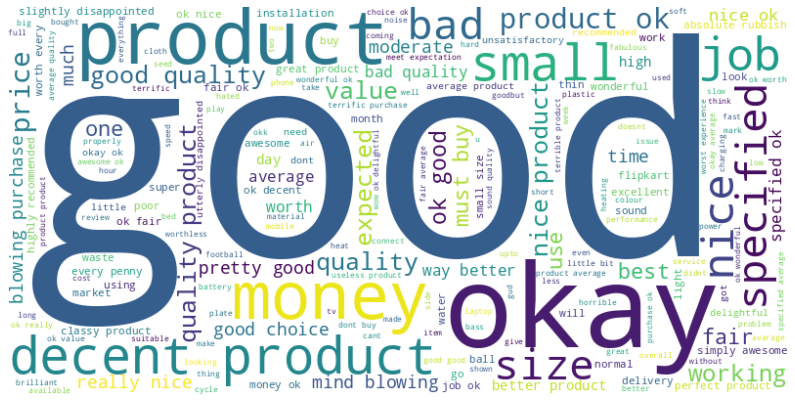

In [ ]:
gen_wc(nue_reviews_text)

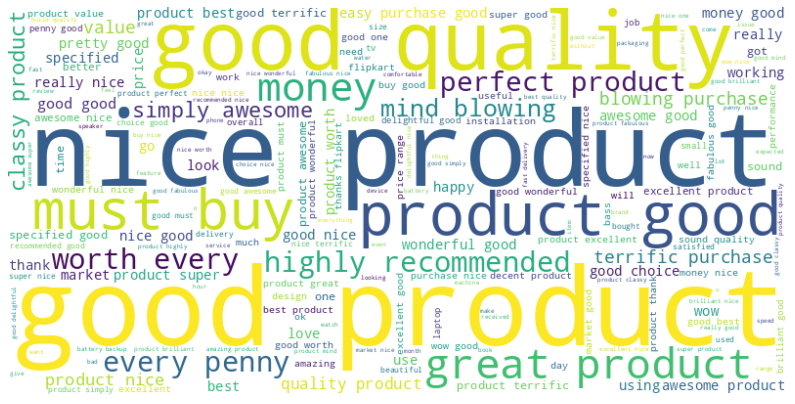

In [ ]:
gen_wc(good_reviews_text)

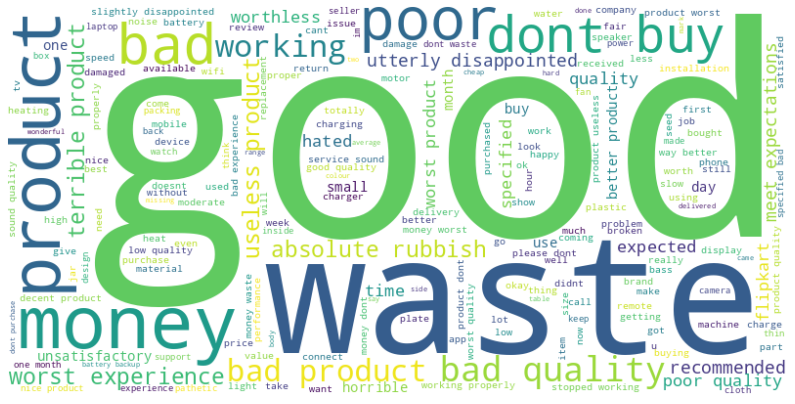

In [ ]:
gen_wc(bad_reviews_text)

In [ ]:
# data['Sentiment']=data['Sentiment'].map({'positive':1, 'negative':2, 'neutral':0})
label_enc = preprocessing.LabelEncoder()
data['Sentiment'] = label_enc.fit_transform(data['Sentiment'].values)

In [ ]:
data['Sentiment'].unique()

array([2, 0, 1])

TF-IDF

In [ ]:
train_com,test_com,train_y,test_y=train_test_split(data['comments'],data['Sentiment'],test_size=0.3,stratify=data['Sentiment'])

In [ ]:
tfidf=TfidfVectorizer()
tfidf.fit(data['comments'])

tf_train_com=tfidf.transform(train_com)
tf_test_com=tfidf.transform(test_com)

NameError: ignored

Count Vect

In [ ]:
cv=CountVectorizer()
cv.fit(data['comments'])

cv_train_com=cv.transform(train_com)
cv_test_com=cv.transform(test_com)

Logistic Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def mdl(clf,x_train,x_test,y_train,y_test):
  clf.fit(x_train,y_train)
  y_pred=clf.predict(x_test)

  print('classification report \n', classification_report(y_test, y_pred))
  print('confusion report \n', confusion_matrix(y_test, y_pred))


logistic and Count Vec

In [ ]:
lg_clf=LogisticRegression()
mdl(lg_clf,cv_train_com, cv_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      7320
           1       0.62      0.42      0.50      2642
           2       0.96      0.98      0.97     44152

    accuracy                           0.93     54114
   macro avg       0.81      0.75      0.77     54114
weighted avg       0.93      0.93      0.93     54114

confusion report 
 [[ 6265   270   785]
 [  557  1107   978]
 [  636   398 43118]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic and TFIDF

In [ ]:
mdl(lg_clf,tf_train_com, tf_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      7320
           1       0.72      0.36      0.48      2642
           2       0.96      0.98      0.97     44152

    accuracy                           0.93     54114
   macro avg       0.84      0.73      0.77     54114
weighted avg       0.93      0.93      0.93     54114

confusion report 
 [[ 6290   135   895]
 [  597   941  1104]
 [  587   233 43332]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Multinomial NB

In [ ]:
mb_clf=MultinomialNB()

NB with CV

In [ ]:
mdl(mb_clf,cv_train_com, cv_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      7320
           1       0.64      0.14      0.23      2642
           2       0.94      0.98      0.96     44152

    accuracy                           0.92     54114
   macro avg       0.80      0.66      0.67     54114
weighted avg       0.91      0.92      0.91     54114

confusion report 
 [[ 6263    54  1003]
 [  720   369  1553]
 [  864   150 43138]]


NB with TF

In [ ]:
mdl(mb_clf,tf_train_com, tf_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.87      0.65      0.75      7320
           1       0.79      0.00      0.01      2642
           2       0.90      0.99      0.94     44152

    accuracy                           0.90     54114
   macro avg       0.85      0.55      0.57     54114
weighted avg       0.89      0.90      0.87     54114

confusion report 
 [[ 4769     0  2551]
 [  370    11  2261]
 [  312     3 43837]]


XG with CV

In [ ]:
xgb_clf=xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,use_label_encoder=False,subsample=0.8, nthread=10, learning_rate=0.01)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
mdl(xgb_clf,cv_train_com, cv_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      7320
           1       0.75      0.25      0.37      2642
           2       0.93      0.98      0.96     44152

    accuracy                           0.92     54114
   macro avg       0.84      0.67      0.71     54114
weighted avg       0.91      0.92      0.91     54114

confusion report 
 [[ 5646    51  1623]
 [  493   658  1491]
 [  634   163 43355]]


In [ ]:
mdl(xgb_clf,tf_train_com, tf_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.85      0.76      0.80      7320
           1       0.83      0.25      0.38      2642
           2       0.93      0.99      0.96     44152

    accuracy                           0.92     54114
   macro avg       0.87      0.66      0.71     54114
weighted avg       0.91      0.92      0.91     54114

confusion report 
 [[ 5567    33  1720]
 [  431   652  1559]
 [  524   103 43525]]


--- Grid search below ---

In [ ]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()

In [ ]:
mdl(lg,tf_train_com, tf_test_com, train_y, test_y)

classification report 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      7320
           1       0.72      0.36      0.48      2642
           2       0.96      0.98      0.97     44152

    accuracy                           0.93     54114
   macro avg       0.84      0.73      0.77     54114
weighted avg       0.93      0.93      0.93     54114

confusion report 
 [[ 6290   135   895]
 [  597   941  1104]
 [  587   233 43332]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.model_selection import GridSearchCV
val={'learning_rate':[0.001,.01,0.1,.0001],'max_depth':[3,5,7],'n_estimators':[50,100,150]}
gs=GridSearchCV(xgb_clf,val,scoring='f1')
gs.fit(tf_train_com, train_y)

In [ ]:
gs_pred=gs.predict(tf_test_com)

In [ ]:
print(confusion_matrix(test_y,gs_pred))

[[  105     0  7215]
 [   25     0  2617]
 [   32     0 44120]]


pytorch and LSTM